In [5]:
import cospar as cs
import pandas as pd
import scipy
import numpy as np
import os
import scanpy as sc
from cospar.plotting import _utils as pl_util

%reload_ext autoreload
%autoreload 2

import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
cs.settings.set_figure_params(format="png", figsize=[4, 3.5], dpi=100, fontsize=12, pointsize=3)

### CoSpar Basics

In [7]:
adata = sc.read_h5ad('../datasets/Weinreb/adata_used.h5ad')
adata

AnnData object with n_obs × n_vars = 44756 × 5000
    obs: 'Time_point', 'Population', 'Annotation', 'Well', 'time_cat', 'leiden', 'comb', 'label_man', 'clones', 'meta_clones'
    var: 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Annotation_colors', 'Time_point_colors', 'comb_colors', 'hvg', 'label_man_colors', 'label_man_sizes', 'leiden', 'leiden_colors', 'log1p', 'meta_clones_colors', 'neighbors', 'paga', 'pca', 'time_cat_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
adata.obs['Clone_ID'] = [name[6:] for name in adata.obs.clones.values]

In [9]:
adata.obs

Time_point Population  Annotation  Well time_cat leiden          comb  \
0             6.0         LK      undiff     2      6.0     16     undiff_16   
1             6.0         LK      undiff     2      6.0     10     undiff_10   
2             6.0         LK    Monocyte     2      6.0      3    Monocyte_3   
4             6.0         LK      undiff     2      6.0      9      undiff_9   
6             6.0         LK  Neutrophil     2      6.0      7  Neutrophil_7   
...           ...        ...         ...   ...      ...    ...           ...   
130875        6.0        LSK      undiff     1      6.0      9      undiff_9   
130876        6.0        LSK      undiff     1      6.0      0      undiff_0   
130877        6.0        LSK  Neutrophil     1      6.0      1  Neutrophil_1   
130879        6.0        LSK    Monocyte     1      6.0     13   Monocyte_13   
130883        6.0        LSK      undiff     1      6.0      0      undiff_0   

                     label_man      clones meta_clones Clone_ID  
0                       prog_2   Clone_573           8      573  
1       prog_Baso_Meg_Ery_Mast  Clone_1440           8     1440  
2                    prog_Mono   Clone_394           0      394  
4                 prog_Meg_Ery  Clone_1972           4     1972  
6                     prog_Neu  Clone_1450           3     1450  
...                        ...         ...         ...      ...  
130875            prog_Meg_Ery    Clone_12           4       12  
130876                  prog_2   Clone_267           8      267  
130877          early_prog_Neu  Clone_3534           1     3534  
130879               prog_Mono  Clone_4945           0     4945  
130883                  prog_2  Clone_1374           5     1374  

[44756 rows x 11 columns]

In [10]:
RNA_count_matrix = scipy.sparse.coo_matrix(np.expm1(adata.raw.X))

In [11]:
adata_orig = cs.pp.initialize_adata_object(
    X_state=RNA_count_matrix,
    gene_names=adata.raw.var_names,
    cell_names=adata.obs.index,
    time_info=adata.obs.Time_point.values,
    state_info=adata.obs.label_man.values,
    X_emb=adata.obsm['X_umap'],
    X_pca=adata.obsm['X_pca'],
    data_des="cospar",
)

creating directory data for saving data
creating directory figure for saving figures
Create new anndata object
Time points with clonal info: []


In [12]:
adata_orig

AnnData object with n_obs × n_vars = 44756 × 25289
    obs: 'time_info', 'state_info'
    uns: 'data_des', 'time_ordering', 'clonal_time_points'
    obsm: 'X_clone', 'X_pca', 'X_emb'

In [13]:
# cs.hf.update_time_ordering(adata_orig, updated_ordering=["3", "10", "17"])

Finding highly variable genes...


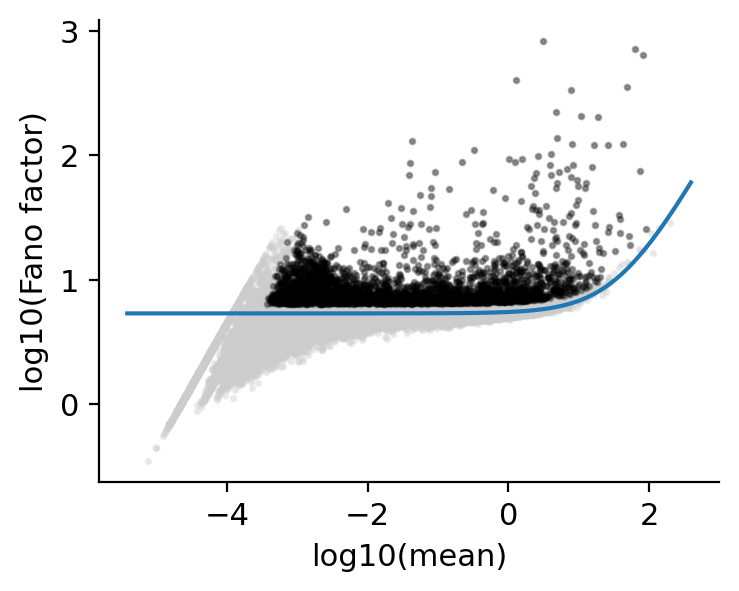

Keeping 3096 genes
Number of selected non-cycling highly variable genes: 3091
Remove 5 cell cycle correlated genes.
adata.var['highly_variable'] updated


100%|██████████| 44756/44756 [00:00<00:00, 1531797.65it/s]

reorder clones


In [14]:
cs.pp.get_highly_variable_genes(adata_orig)
cs.pp.remove_cell_cycle_correlated_genes(adata_orig, corr_threshold=0.5, confirm_change=True)
cs.pp.get_X_clone(adata_orig, adata.obs.index.values, adata.obs.Clone_ID.values)

<Axes: title={'center': 'ID: 1'}>

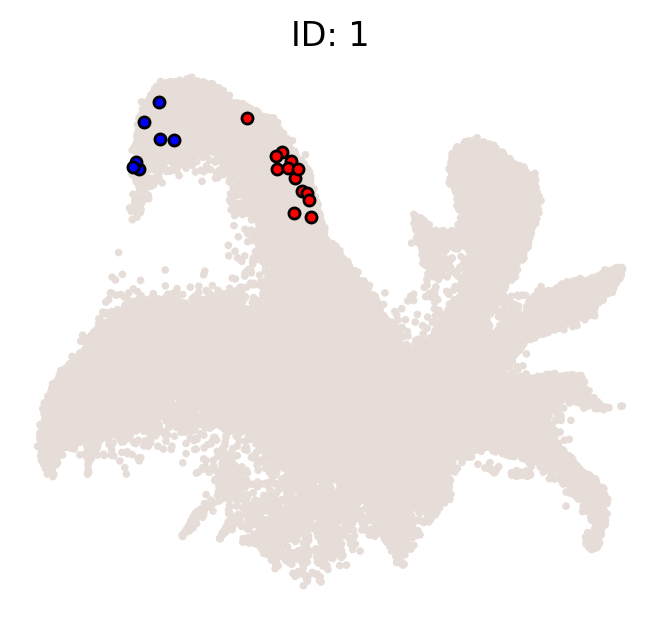

In [15]:
cs.pl.clones_on_manifold(
    adata_orig,
    selected_clone_list=[1],
    color_list=["black", "red", "blue"],
    clone_markersize=8,
)

In [16]:
selected_fates = ["Ery", "Meg", "Eos", "Mast", "DC", "Mono", "Neu", "pDC", "Ly", 'Baso']

Data saved at adata.uns['barcode_heatmap']


<Axes: title={'center': '1989 clones'}>

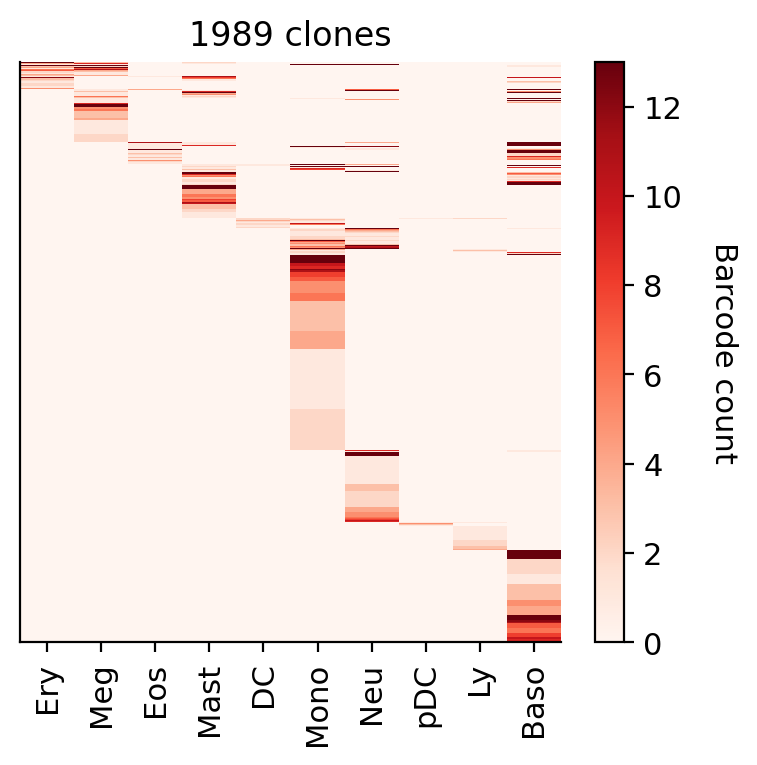

In [17]:
cs.pl.barcode_heatmap(
    adata_orig,
    selected_fates=selected_fates,
    color_bar=True,
    log_transform=False,
    fig_height=4
)

In [18]:
# cs.pl.barcode_heatmap(
#     adata_orig,
#     selected_fates=selected_fates,
#     color_bar=True,
#     log_transform=False,
#     binarize=True,
#     fig_height=4
# )

normalize by X_clone
each cluster do not have a unique time point. Simply column-normalize the matrix
Results saved as dictionary at adata.uns['fate_coupling_X_clone']


<Axes: title={'center': 'source: X_clone'}>

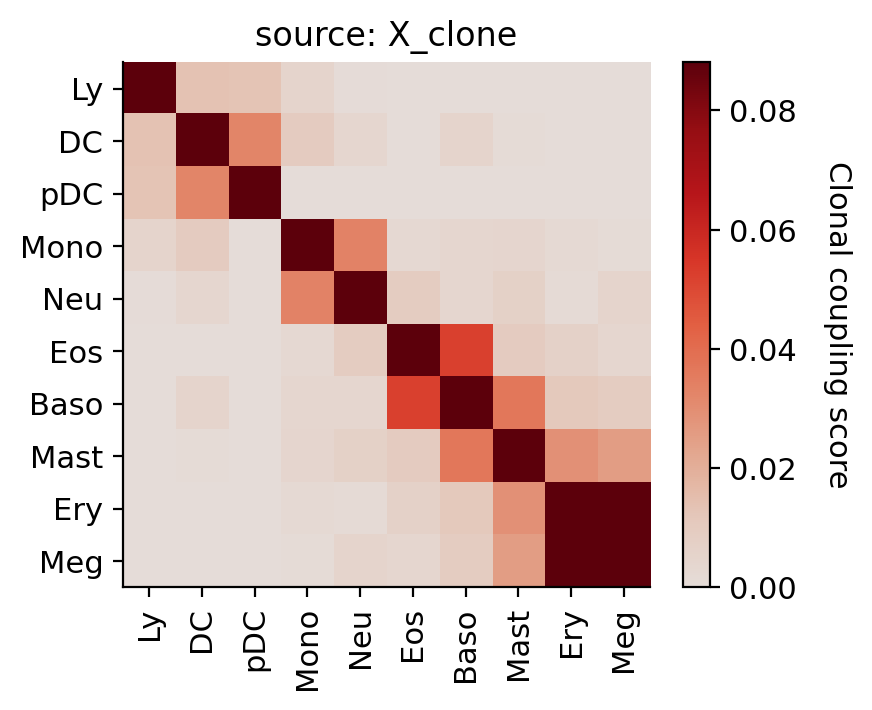

In [19]:
cs.tl.fate_coupling(adata_orig, selected_fates=selected_fates, source="X_clone") 
cs.pl.fate_coupling(adata_orig, source="X_clone")

Strong coupling implies the existence of bi-potent or multi-potent cell states at the time of barcoding. You can visualize the fate hierarchy by a simple neighbor-joining method

In [20]:
cs.tl.fate_hierarchy(adata_orig, selected_fates=selected_fates, source="X_clone")
cs.pl.fate_hierarchy(adata_orig, source="X_clone")

normalize by X_clone
each cluster do not have a unique time point. Simply column-normalize the matrix
normalize by X_clone
each cluster do not have a unique time point. Simply column-normalize the matrix
normalize by X_clone
each cluster do not have a unique time point. Simply column-normalize the matrix
normalize by X_clone
each cluster do not have a unique time point. Simply column-normalize the matrix
normalize by X_clone
each cluster do not have a unique time point. Simply column-normalize the matrix
normalize by X_clone
each cluster do not have a unique time point. Simply column-normalize the matrix
normalize by X_clone
each cluster do not have a unique time point. Simply column-normalize the matrix
normalize by X_clone
each cluster do not have a unique time point. Simply column-normalize the matrix
Results saved as dictionary at adata.uns['fate_hierarchy_X_clone']

            /-pDC
         /-|
      /-|   \-DC
     |  |
   /-|   \-Ly
  |  |
  |  |   /-Neu
  |   \-|
  |      \-M

/ssd/users/mingzegao/.conda/envs/clonetrans/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ssd/users/mingzegao/.conda/envs/clonetrans/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


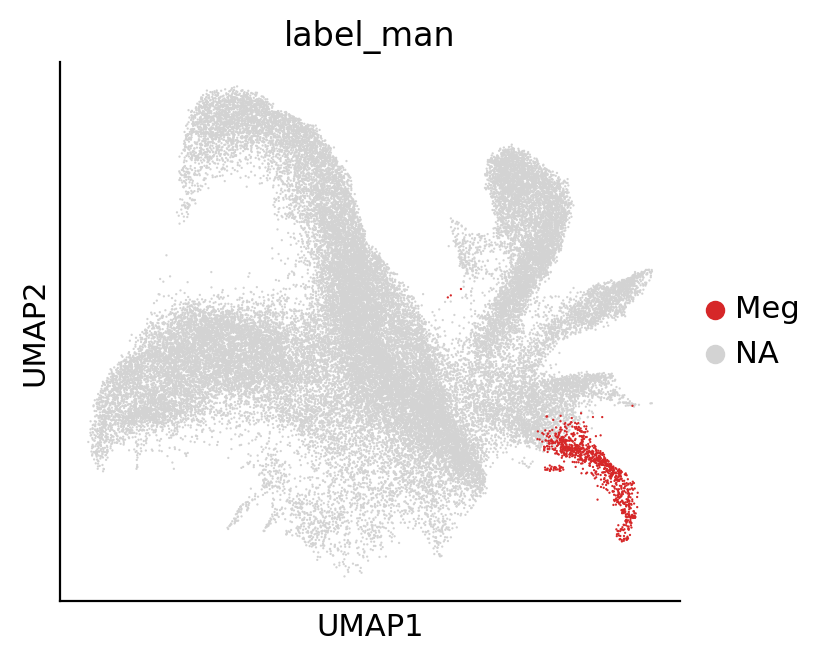

In [21]:
sc.pl.umap(adata, color="label_man", groups='Meg')

In [ ]:
df_results = []

for fate in selected_fates:
    cs.tl.clonal_fate_bias(adata_orig, selected_fate=fate, alternative="two-sided")
    cs.pl.clonal_fate_bias(adata_orig)
    df_results.append(adata_orig.uns["clonal_fate_bias"])

In [ ]:
for idx, fate in enumerate(selected_fates):
    df_results[idx].to_csv(f'./data/fate_bias_weinreb_cospar_{fate}.csv')

### Transition Map Inference

In [20]:
adata_all_latert = adata_orig.copy()
adata_all_latert = cs.tmap.infer_Tmap_from_multitime_clones(
    adata_all_latert,
    clonal_time_points=['2.0', '4.0', '6.0'],
    later_time_point='6.0',
    smooth_array=[20, 15, 10, 5],
    max_iter_N=10,
)

--> Phase I: time elapsed --  9.91997480392456
--> Phase II: time elapsed --  17.70153570175171
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--> Clone id: 2000
-----------Total used time: 7785.178625583649 s ------------


In [21]:
adata_all_latert

AnnData object with n_obs × n_vars = 44756 × 25289
    obs: 'time_info', 'state_info', 'n_counts'
    var: 'highly_variable'
    uns: 'data_des', 'time_ordering', 'clonal_time_points', 'clone_id', 'barcode_heatmap', 'available_map', 'fate_coupling_X_clone', 'fate_hierarchy_X_clone', 'clonal_fate_bias', 'neighbors', 'Tmap_cell_id_t1', 'Tmap_cell_id_t2', 'clonal_cell_id_t1', 'clonal_cell_id_t2', 'sp_idx', 'transition_map', 'intraclone_transition_map'
    obsm: 'X_clone', 'X_pca', 'X_emb'
    obsp: 'distances', 'connectivities'

### Others

In [23]:
coarse_X_clone, mega_cluster_list = cs.tl.coarse_grain_clone_over_cell_clusters(
    adata_orig,
    selected_times=['2.0', '4.0', '6.0'],
    selected_fates=selected_fates
)

In [24]:
coarse_X_clone

array([[0., 0., 0., ..., 0., 5., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
coarse_X_clone.shape

(10, 4214)

In [26]:
coarse_X_clone_new = pl_util.custom_hierachical_ordering(np.arange(coarse_X_clone.shape[0]), coarse_X_clone)
coarse_X_clone_new

array([[12.,  1.,  7., ...,  0.,  0.,  0.],
       [16.,  1., 20., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  4., ...,  0.,  0.,  0.]])

In [27]:
coarse_X_clone_new.shape

(10, 4214)

### Transition Map Visualization

/ssd/users/mingzegao/.conda/envs/clonetrans/lib/python3.9/site-packages/cospar/tool/_utils.py:235: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state_annote[cell_id_t2] == yy


Results saved at adata.obs['fate_map_transition_map_Neu']
Results saved at adata.obs['fate_map_transition_map_Mono']


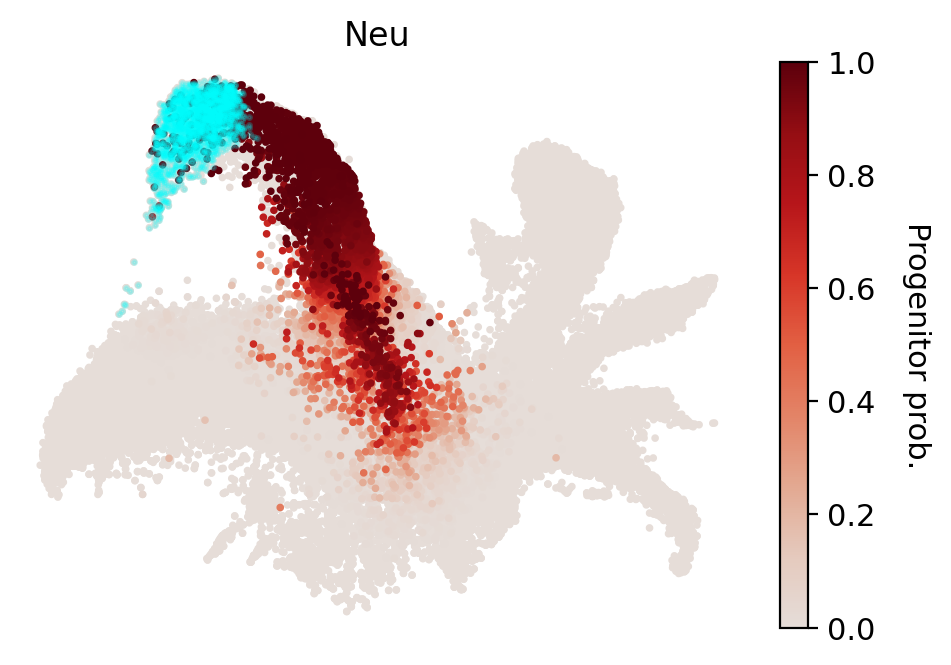

In [33]:
cs.tl.fate_map(
    adata_all_latert,
    selected_fates=["Neu", "Mono"],
    source="transition_map",
    map_backward=True,
)

cs.pl.fate_map(
    adata_all_latert,
    selected_fates=["Neu"],
    source="transition_map",
    plot_target_state=True,
    show_histogram=False,
)

/ssd/users/mingzegao/.conda/envs/clonetrans/lib/python3.9/site-packages/cospar/tool/_utils.py:235: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state_annote[cell_id_t2] == yy


Results saved at adata.obs['fate_map_transition_map_Ery']
Results saved at adata.obs['fate_map_transition_map_prog_Mono']
Results saved at adata.obs['fate_map_transition_map_early_prog_Neu']
Results saved at adata.obs['fate_map_transition_map_prog_Meg_Ery']
Results saved at adata.obs['fate_map_transition_map_prog_Baso_Meg_Ery_Mast']
Results saved at adata.obs['fate_map_transition_map_Eos']
Results saved at adata.obs['fate_map_transition_map_prog_Ly_pDC']
Results saved at adata.obs['fate_map_transition_map_Meg']
Results saved at adata.obs['fate_map_transition_map_prog_4']
Results saved at adata.obs['fate_map_transition_map_prog_Neu']
Results saved at adata.obs['fate_map_transition_map_Mast']
Results saved at adata.obs['fate_map_transition_map_prog_1']
Results saved at adata.obs['fate_map_transition_map_DC']
Results saved at adata.obs['fate_map_transition_map_prog_Baso_Eos']
Results saved at adata.obs['fate_map_transition_map_Baso']
Results saved at adata.obs['fate_map_transition_map_pro

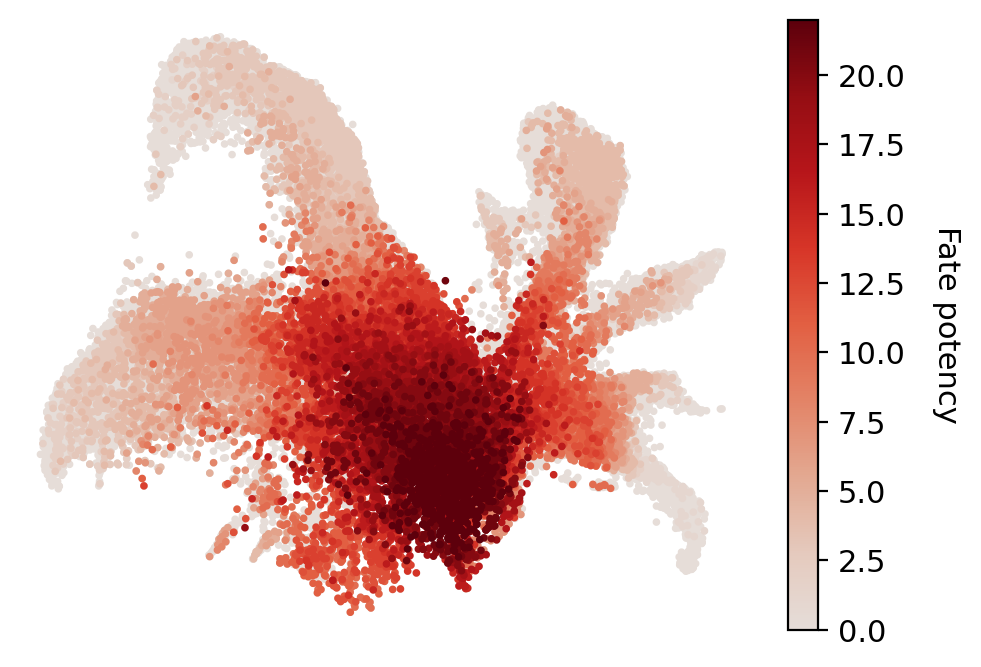

In [34]:
cs.tl.fate_potency(
    adata_all_latert,
    source="transition_map",
    map_backward=True,
    method="norm-sum",
    fate_count=True,
)

cs.pl.fate_potency(adata_all_latert, source="transition_map")

/ssd/users/mingzegao/.conda/envs/clonetrans/lib/python3.9/site-packages/cospar/tool/_utils.py:235: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state_annote[cell_id_t2] == yy


Results saved at adata.obs['fate_map_transition_map_Neu']
Results saved at adata.obs['fate_map_transition_map_Mono']
Results saved at adata.obs['fate_bias_transition_map_Neu*Mono']


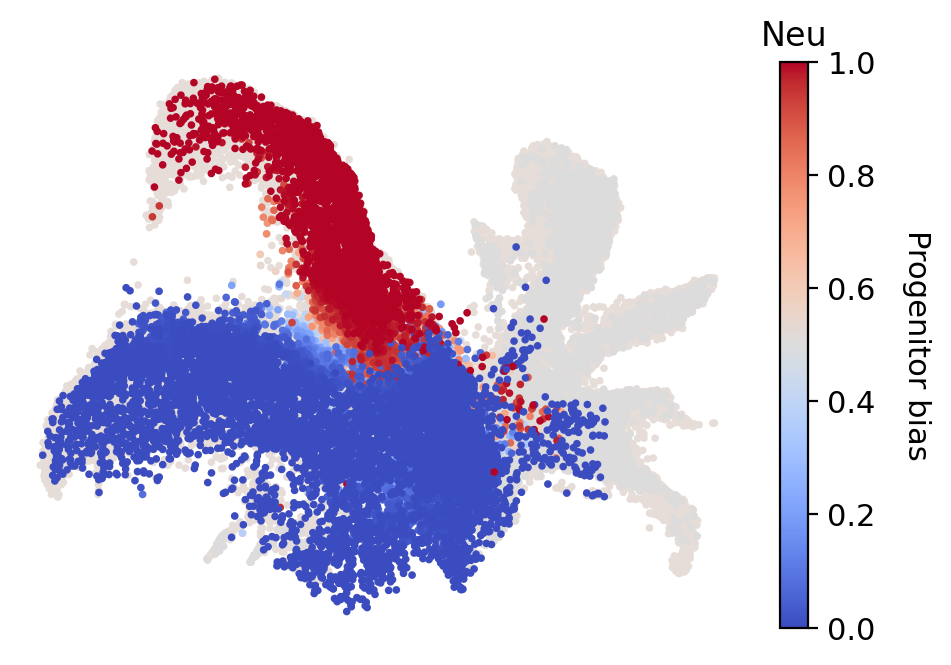

In [35]:
cs.tl.fate_bias(
    adata_all_latert,
    selected_fates=["Neu", "Mono"],
    source="transition_map",
    pseudo_count=0,
)

cs.pl.fate_bias(
    adata_all_latert,
    selected_fates=["Neu", "Mono"],
    source="transition_map",
    plot_target_state=False,
)

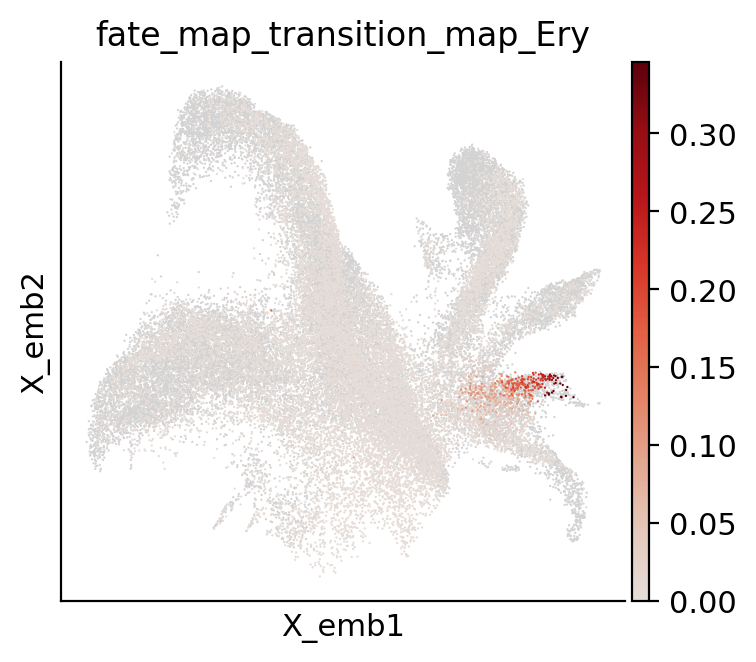

In [36]:
cs.pl.embedding(adata_all_latert, color=["fate_map_transition_map_Ery"], save='ery.svg')

/ssd/users/mingzegao/.conda/envs/clonetrans/lib/python3.9/site-packages/cospar/tool/_utils.py:235: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state_annote[cell_id_t2] == yy


Results saved at adata.obs['fate_map_transition_map_Neu']
Results saved at adata.obs['fate_map_transition_map_Mono']
Results saved at adata.obs['fate_bias_transition_map_Neu*Mono']
Results saved at adata.obs[f'progenitor_transition_map_Neu'] and adata.obs[f'diff_trajectory_transition_map_Neu']
Results saved at adata.obs[f'progenitor_transition_map_Mono'] and adata.obs[f'diff_trajectory_transition_map_Mono']


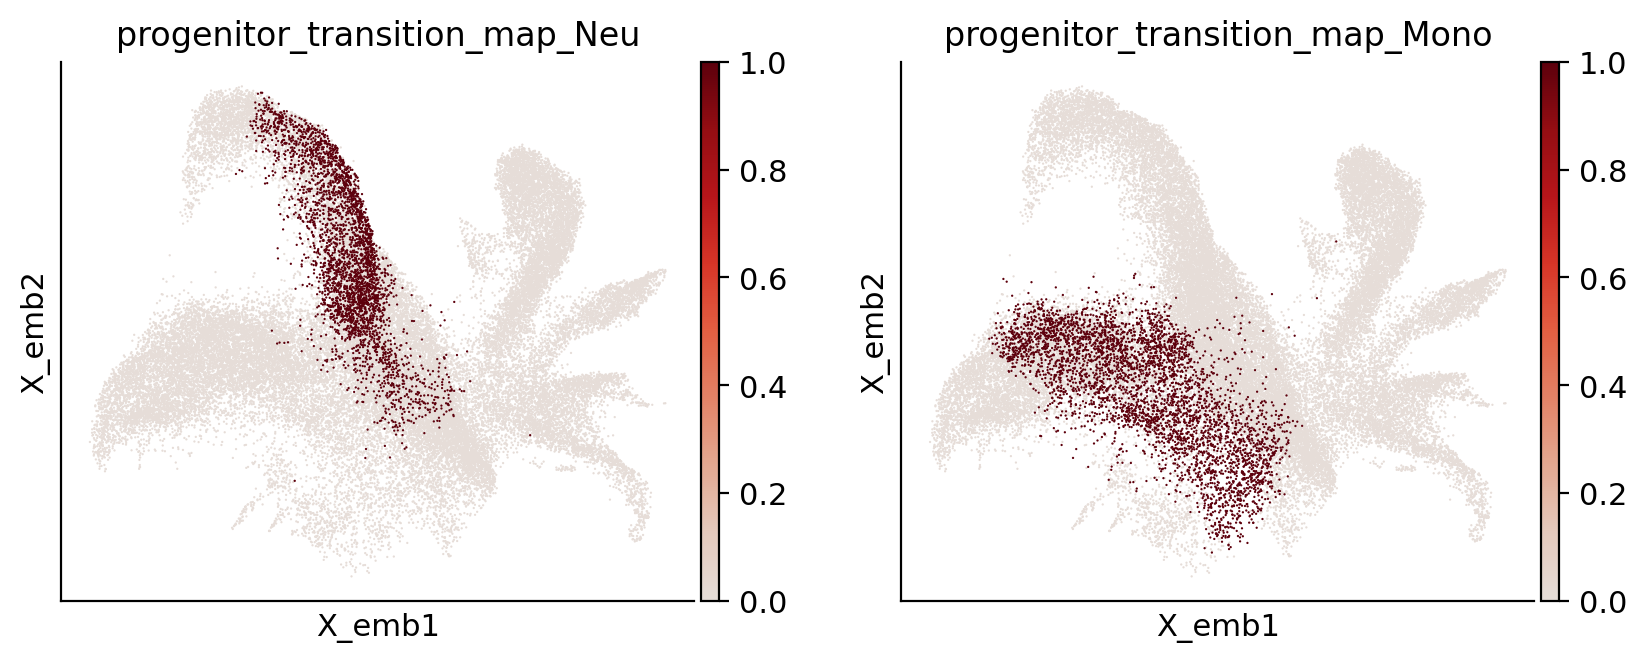

In [37]:
cs.tl.progenitor(
    adata_all_latert,
    selected_fates=["Neu", "Mono"],
    source="transition_map",
    map_backward=True,
    bias_threshold_A=0.5,
    bias_threshold_B=0.5,
    sum_fate_prob_thresh=0.2,
    avoid_target_states=True,
)

cs.pl.embedding(adata_all_latert, color=['progenitor_transition_map_Neu', 'progenitor_transition_map_Mono'])

In [38]:
import numpy as np

cell_group_A = np.array(adata_all_latert.obs["diff_trajectory_transition_map_Neu"])
cell_group_B = np.array(adata_all_latert.obs["diff_trajectory_transition_map_Mono"])

dge_gene_A, dge_gene_B = cs.tl.differential_genes(
    adata_all_latert, cell_group_A=cell_group_A, cell_group_B=cell_group_B, FDR_cutoff=0.05
)

In [39]:
dge_gene_A

index      gene         Qvalue      mean_1     mean_2     ratio
0        66       Ngp   0.000000e+00  339.097198   1.208701  7.266605
1        28    S100a9   0.000000e+00  385.598572   9.694564  5.175887
2         2       Ltf   0.000000e+00   26.975346   0.075929  4.700500
3        24    S100a8   0.000000e+00  216.882568  10.154605  4.287839
4        79      Camp  1.814781e-291   19.093433   0.098419  4.193224
...     ...       ...            ...         ...        ...       ...
2086   2912   Mybbp1a   1.266455e-03    0.297735   0.297061  0.000749
2087   3800       Ivd   2.844258e-02    0.276049   0.275472  0.000652
2088   3087  Slc25a12   3.148526e-03    0.472019   0.471367  0.000640
2089   3199      Msi2   4.903226e-03    0.242451   0.241920  0.000617
2090   4066    Sptlc1   4.876199e-02    0.730189   0.730091  0.000082

[2091 rows x 6 columns]

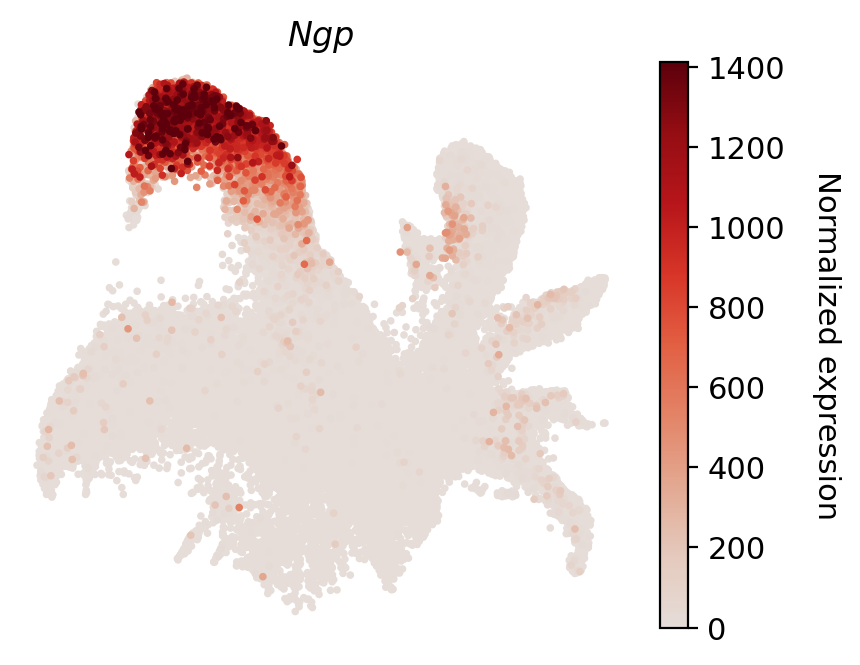

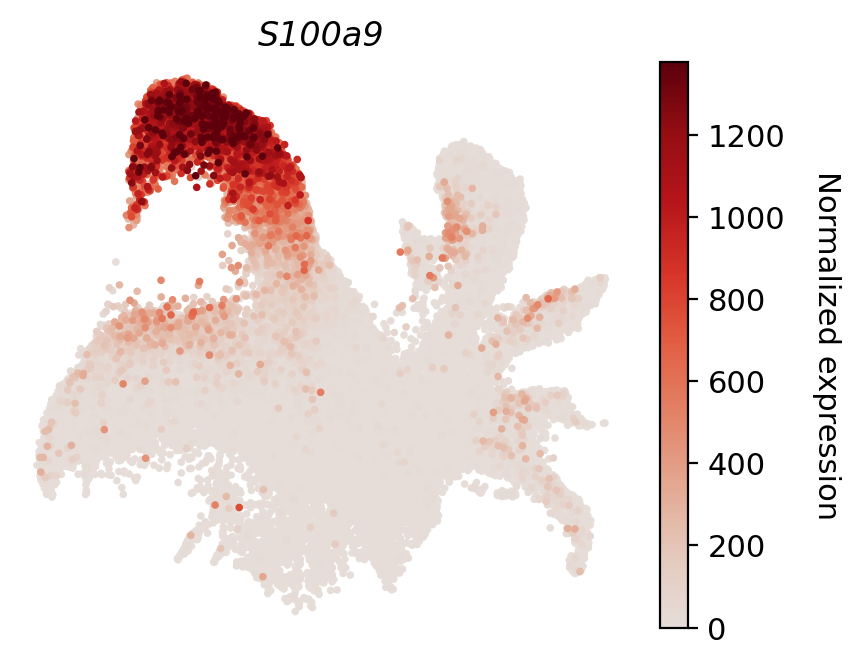

In [40]:
selected_genes = dge_gene_A["gene"][:2]
cs.pl.gene_expression_on_manifold(
    adata_all_latert, selected_genes=selected_genes, color_bar=True, savefig=False
)

--> Using relative gene expression. Range [0,1]


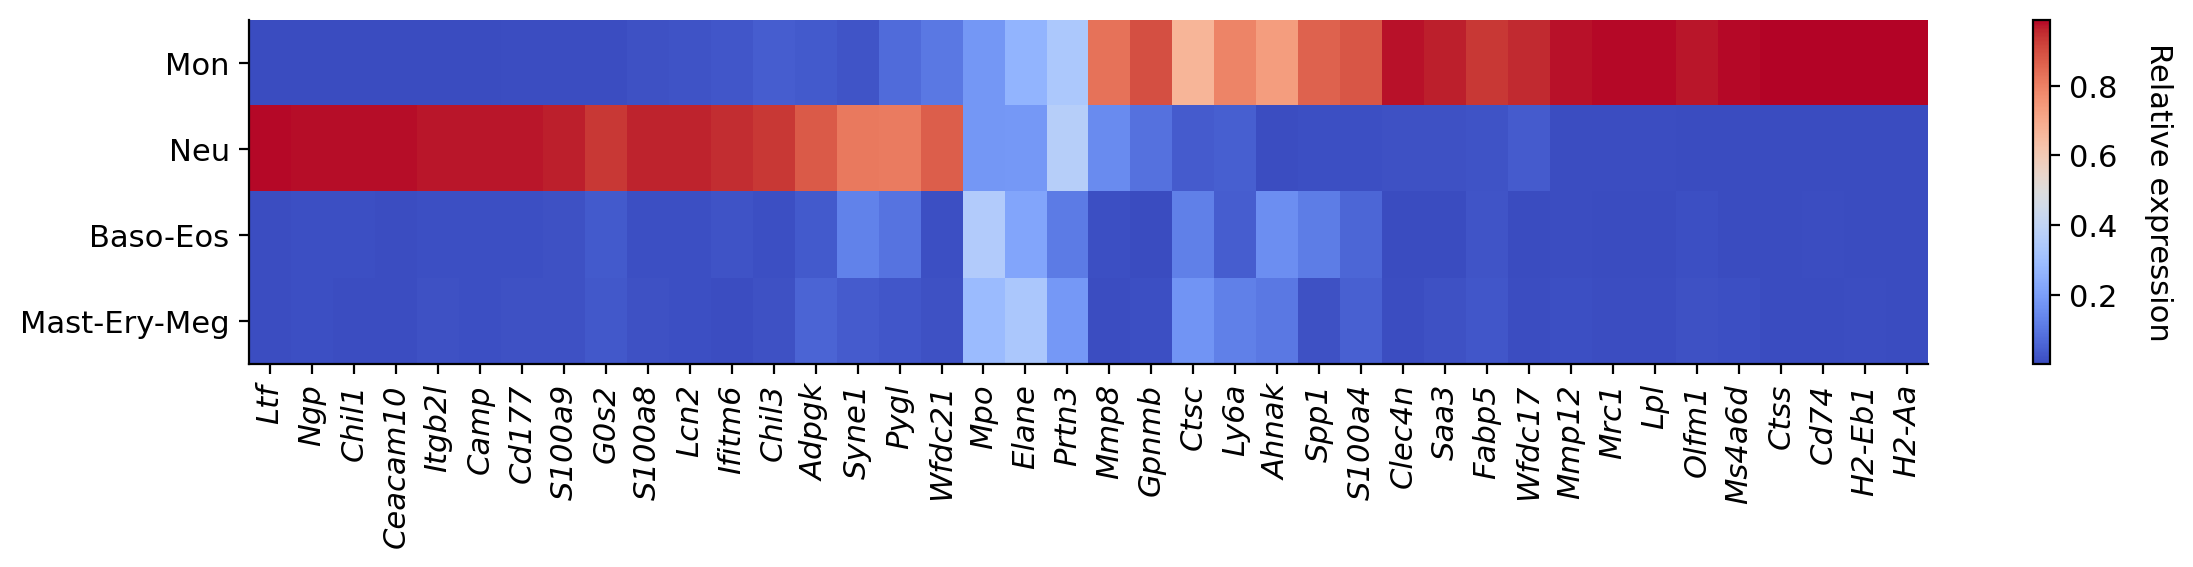

In [41]:
gene_list = list(dge_gene_A["gene"][:20]) + list(dge_gene_B["gene"][:20]) 

selected_fates = [
    "Neu",
    "Mono",
    ["Baso", "Eos"],
    ["Mast", "Ery", "Meg"],
]
renames = ["Neu", "Mon", "Baso-Eos", "Mast-Ery-Meg"]

gene_expression_matrix = cs.pl.gene_expression_heatmap(
    adata_all_latert,
    selected_genes=gene_list,
    selected_fates=selected_fates,
    rename_fates=renames,
    fig_width=12,
)

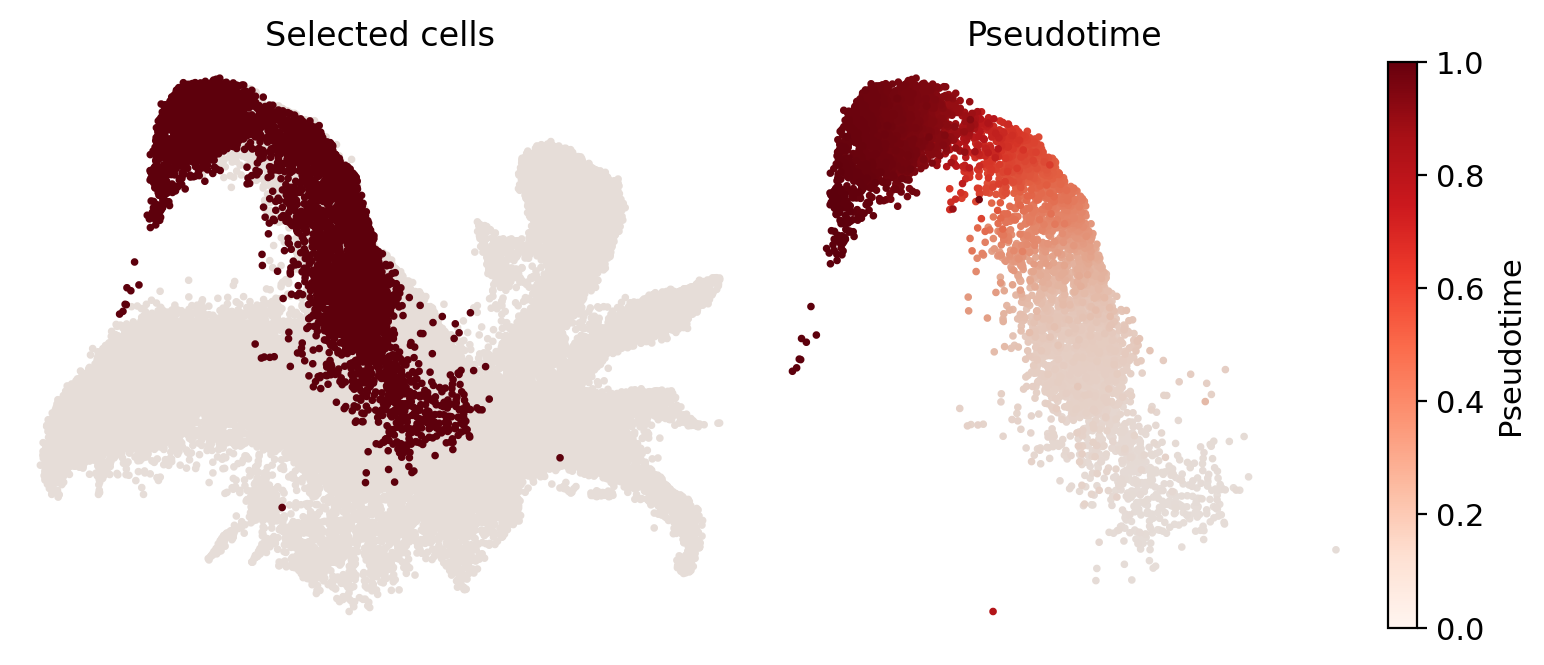

In [42]:
gene_name_list = ["Gata1", "Mpo", "Elane", "S100a8"]
selected_fate = "Neu"

cs.pl.gene_expression_dynamics(
    adata_all_latert,
    selected_fate,
    gene_name_list,
    traj_threshold=0.2,
    invert_PseudoTime=False,
    compute_new=True,
    gene_exp_percentile=99,
    n_neighbors=15,
    plot_raw_data=False,
)

### Benchmark with Gillespie

#### Init Gillespie Results

In [28]:
import os 
os.chdir('/ssd/users/mingzegao/clonaltrans/clonaltrans/')

path = '../trails/checkpoints/WeinrebDynamicRates/0301_112802/model_last.pt'
model = torch.load(path, map_location='cpu')
device = torch.device('cpu')

import os 
os.chdir('/ssd/users/mingzegao/clonaltrans/')

In [29]:
anno = pd.read_csv(os.path.join(
    model.config['data_loader']['args']['data_dir'], 
    model.config['data_loader']['args']['annots']
))
cluster_names = anno['populations'].values[:model.N.shape[2]]

In [30]:
gillespie_dir='./trails/checkpoints/WeinrebDynamicGillespie/0301_211649/models/'

#### Performance Comparison

In [31]:
from clonaltrans.pl import with_cospar

/ssd/users/mingzegao/.conda/envs/clonetrans/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/ssd/users/mingzegao/.conda/envs/clonetrans/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


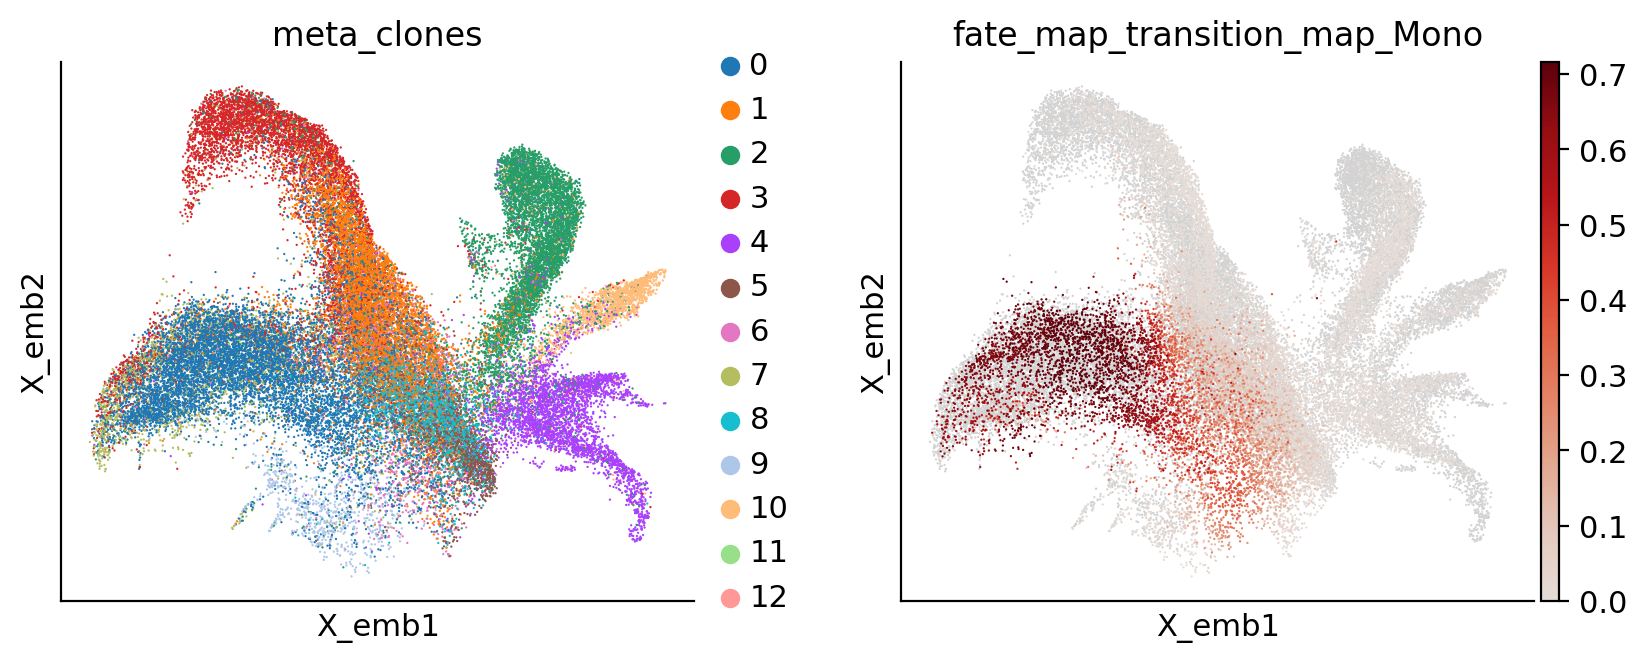

In [43]:
adata_all_latert.obs['meta_clones'] = adata.obs['meta_clones'].values
adata_all_latert.obs['Clone_ID'] = adata.obs['Clone_ID'].values

cs.pl.embedding(adata_all_latert, color=["meta_clones", "fate_map_transition_map_Mono"])

In [44]:
adata.obs[adata.obs['meta_clones'] == '0']

Time_point Population Annotation  Well time_cat leiden         comb  \
2             6.0         LK   Monocyte     2      6.0      3   Monocyte_3   
8             6.0         LK   Monocyte     2      6.0     13  Monocyte_13   
25            6.0         LK     undiff     2      6.0      8     undiff_8   
29            6.0         LK   Monocyte     2      6.0      3   Monocyte_3   
30            6.0         LK   Monocyte     2      6.0     13  Monocyte_13   
...           ...        ...        ...   ...      ...    ...          ...   
130852        6.0        LSK     undiff     1      6.0      6     undiff_6   
130857        6.0        LSK   Monocyte     1      6.0      3   Monocyte_3   
130865        6.0        LSK     undiff     1      6.0      1     undiff_1   
130869        6.0        LSK     undiff     1      6.0     11    undiff_11   
130879        6.0        LSK   Monocyte     1      6.0     13  Monocyte_13   

        label_man      clones meta_clones Clone_ID  
2       prog_Mono   Clone_394           0      394  
8       prog_Mono  Clone_5624           0     5624  
25         prog_4  Clone_3438           0     3438  
29      prog_Mono  Clone_1700           0     1700  
30      prog_Mono  Clone_3887           0     3887  
...           ...         ...         ...      ...  
130852     prog_3   Clone_214           0      214  
130857  prog_Mono  Clone_2096           0     2096  
130865     prog_4   Clone_141           0      141  
130869     prog_2  Clone_4417           0     4417  
130879  prog_Mono  Clone_4945           0     4945  

[9651 rows x 11 columns]

In [45]:
selected_fates = ["Ery", "Meg", "Eos", "Mast", "DC", "Mono", "Neu", "pDC", "Ly", 'Baso']

In [46]:
from clonaltrans.pl import get_fate_prob
aggre = get_fate_prob(model, cluster_names, gillespie_dir)

In [ ]:
aggre['clone_0']

/ssd/users/mingzegao/clonaltrans/clonaltrans/pl/benchmark.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/ssd/users/mingzegao/clonaltrans/clonaltrans/pl/benchmark.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/ssd/users/mingzegao/clonaltrans/clonaltrans/pl/benchmark.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/ssd/users/mingzegao/clonaltrans/clonaltrans/pl/benchmark.py:70: FutureWarning: The default of ob

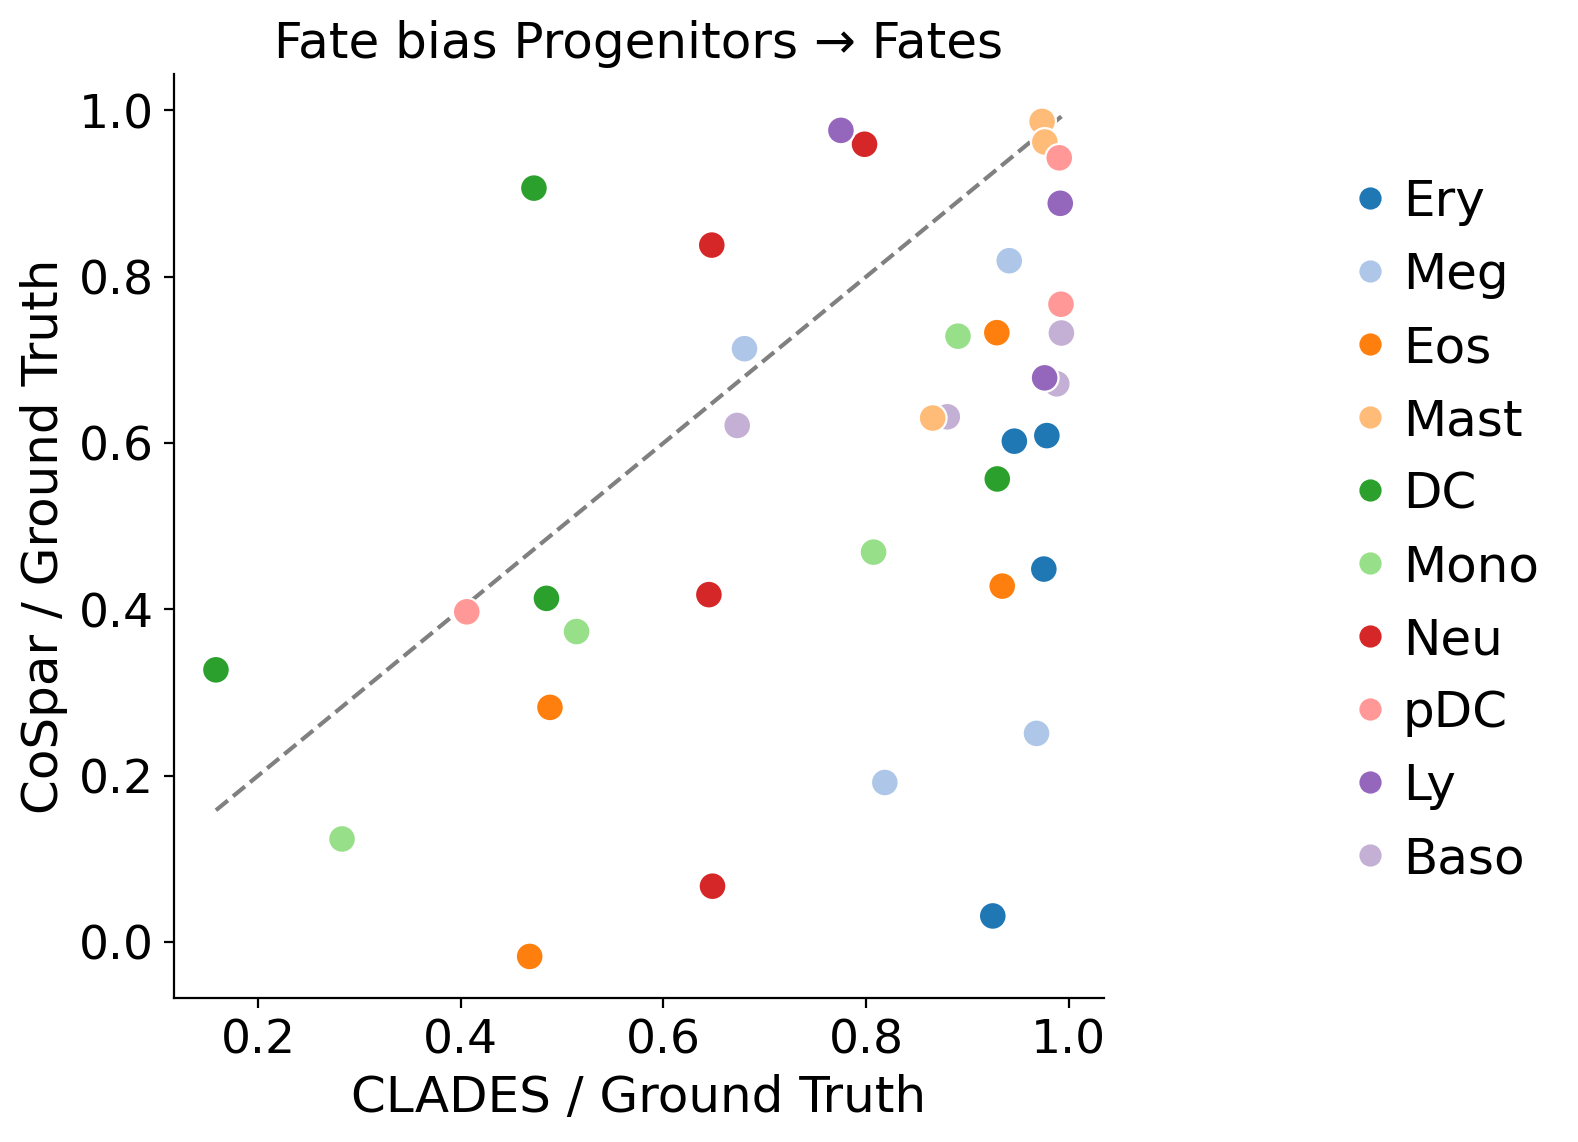

In [47]:
from clonaltrans.pl import with_cospar_all
with_cospar_all(
    adata_all_latert, 
    adata, 
    model, 
    cluster_names,
    gillespie_dir,
    selected_fates,
    save='weinrebcosparfate'
)

/ssd/users/mingzegao/clonaltrans/clonaltrans/pl/benchmark.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/ssd/users/mingzegao/clonaltrans/clonaltrans/pl/benchmark.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/ssd/users/mingzegao/clonaltrans/clonaltrans/pl/benchmark.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/ssd/users/mingzegao/clonaltrans/clonaltrans/pl/benchmark.py:70: FutureWarning: The default of ob

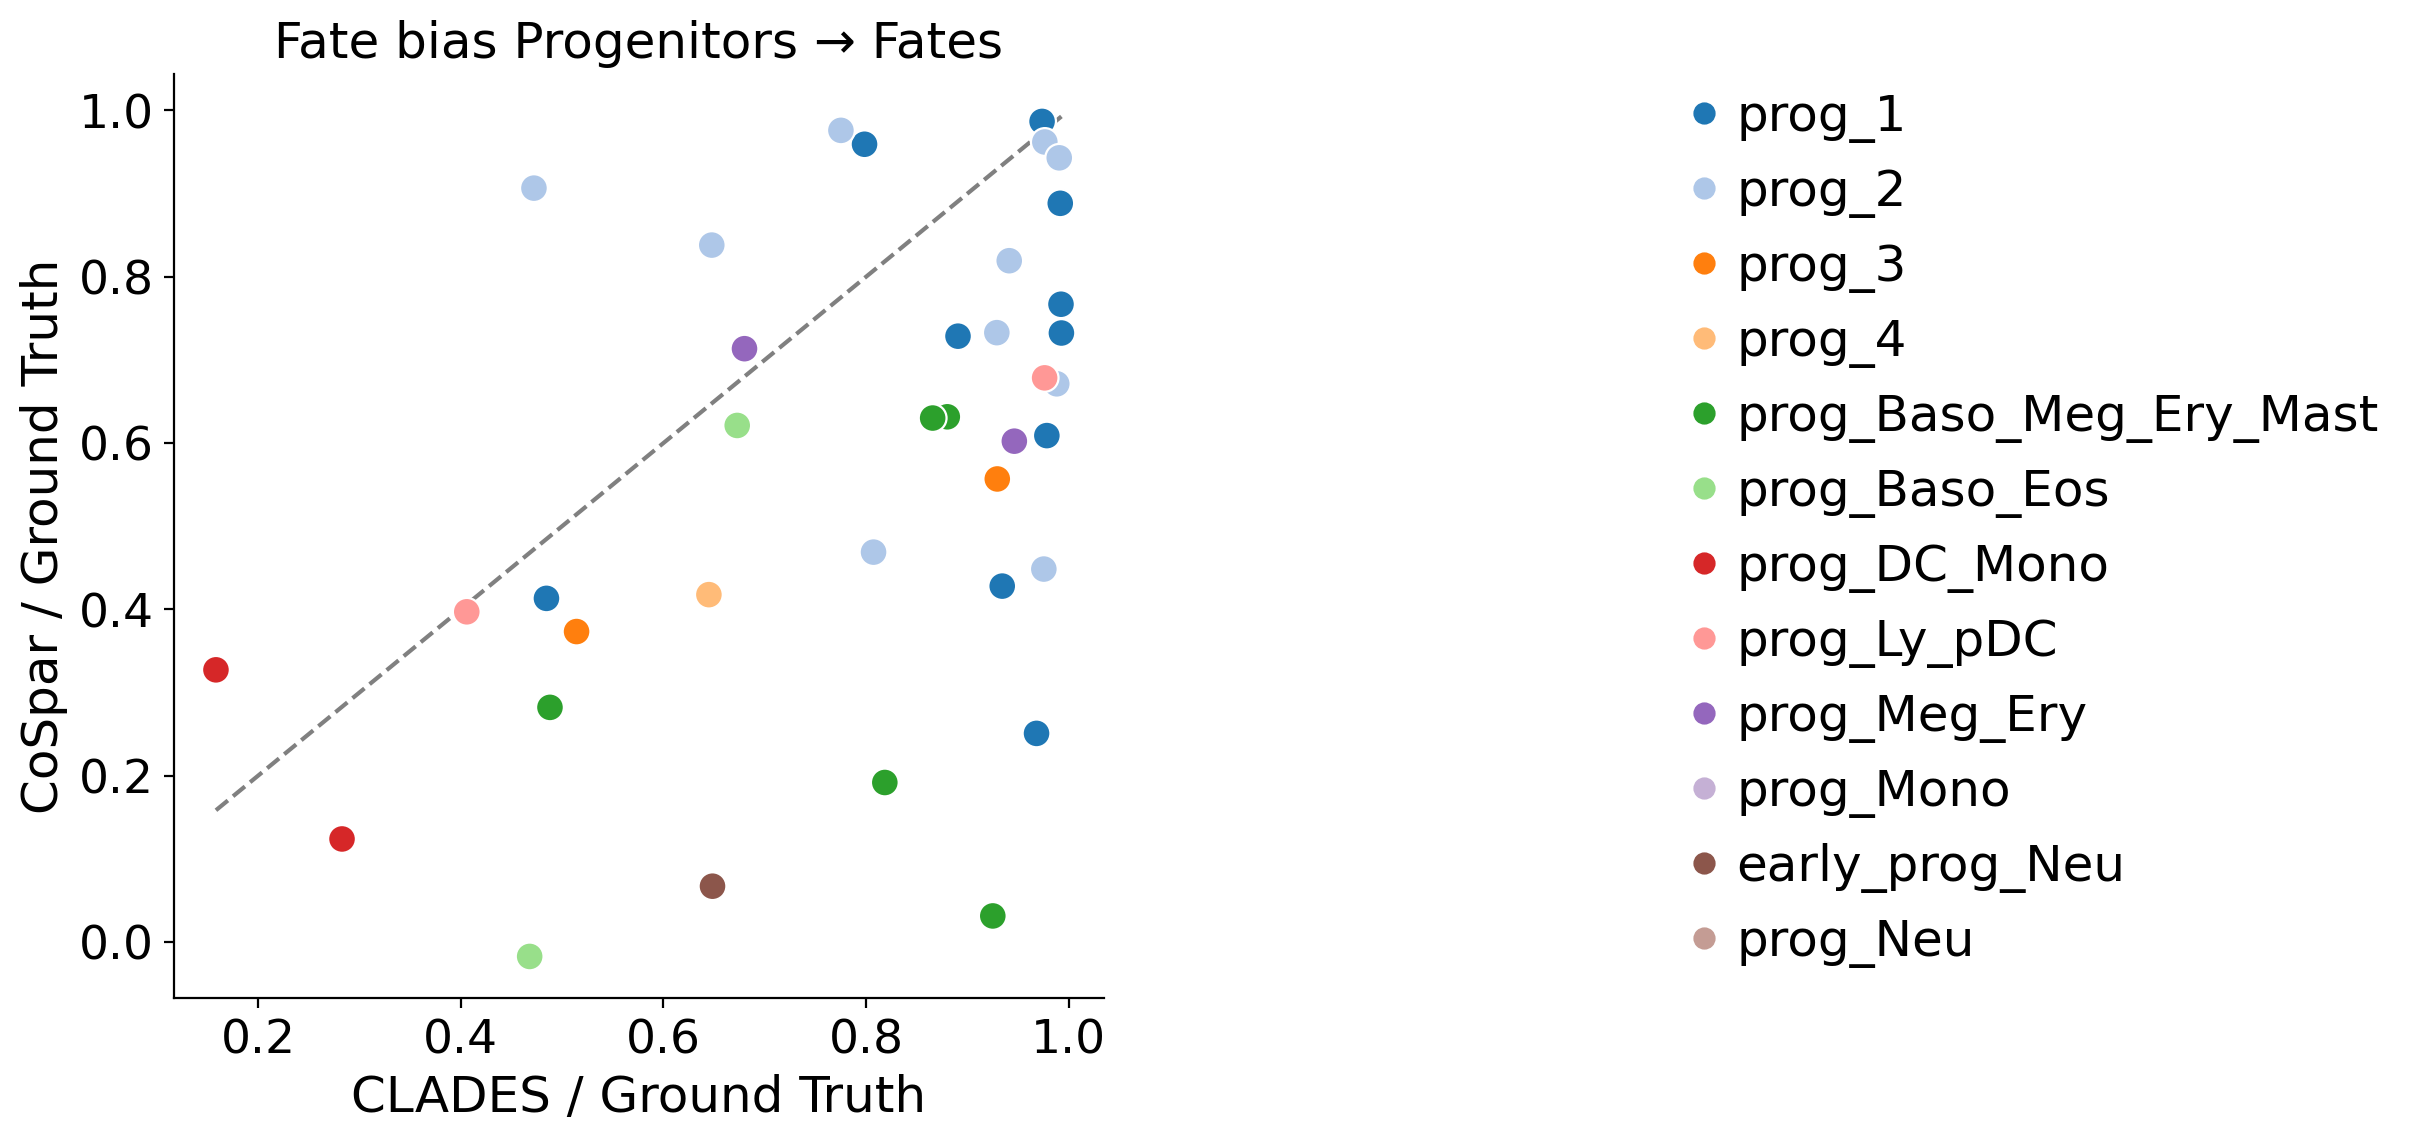

In [51]:
from clonaltrans.pl import with_cospar_all
with_cospar_all(
    adata_all_latert, 
    adata, 
    model, 
    cluster_names,
    gillespie_dir,
    selected_fates,
    show_fate=False,
    save='weinrebcosparprog'
)

In [49]:
adata_all_latert.obs['meta_clones'] = adata.obs['meta_clones'].values
adata_all_latert.obs['Clone_ID'] = adata.obs['Clone_ID'].values

df = adata_all_latert.obs[adata_all_latert.obs[f'fate_map_transition_map_Mono'] >= 0]
df = df[df['state_info'] == 'prog_2']

cospar_bias = pd.DataFrame(
        df.groupby('meta_clones')[f'fate_map_transition_map_Mono'].mean()
    )
cospar_bias

/tmp/ipykernel_3737056/3742962537.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


fate_map_transition_map_Mono
meta_clones                              
0                                0.166543
1                                0.074204
2                                0.070456
3                                0.157115
4                                0.063304
5                                0.043730
6                                0.182795
7                                0.305291
8                                0.041697
9                                0.231598
10                               0.049080
11                                    NaN
12                               0.203645

/ssd/users/mingzegao/clonaltrans/clonaltrans/pl/benchmark.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


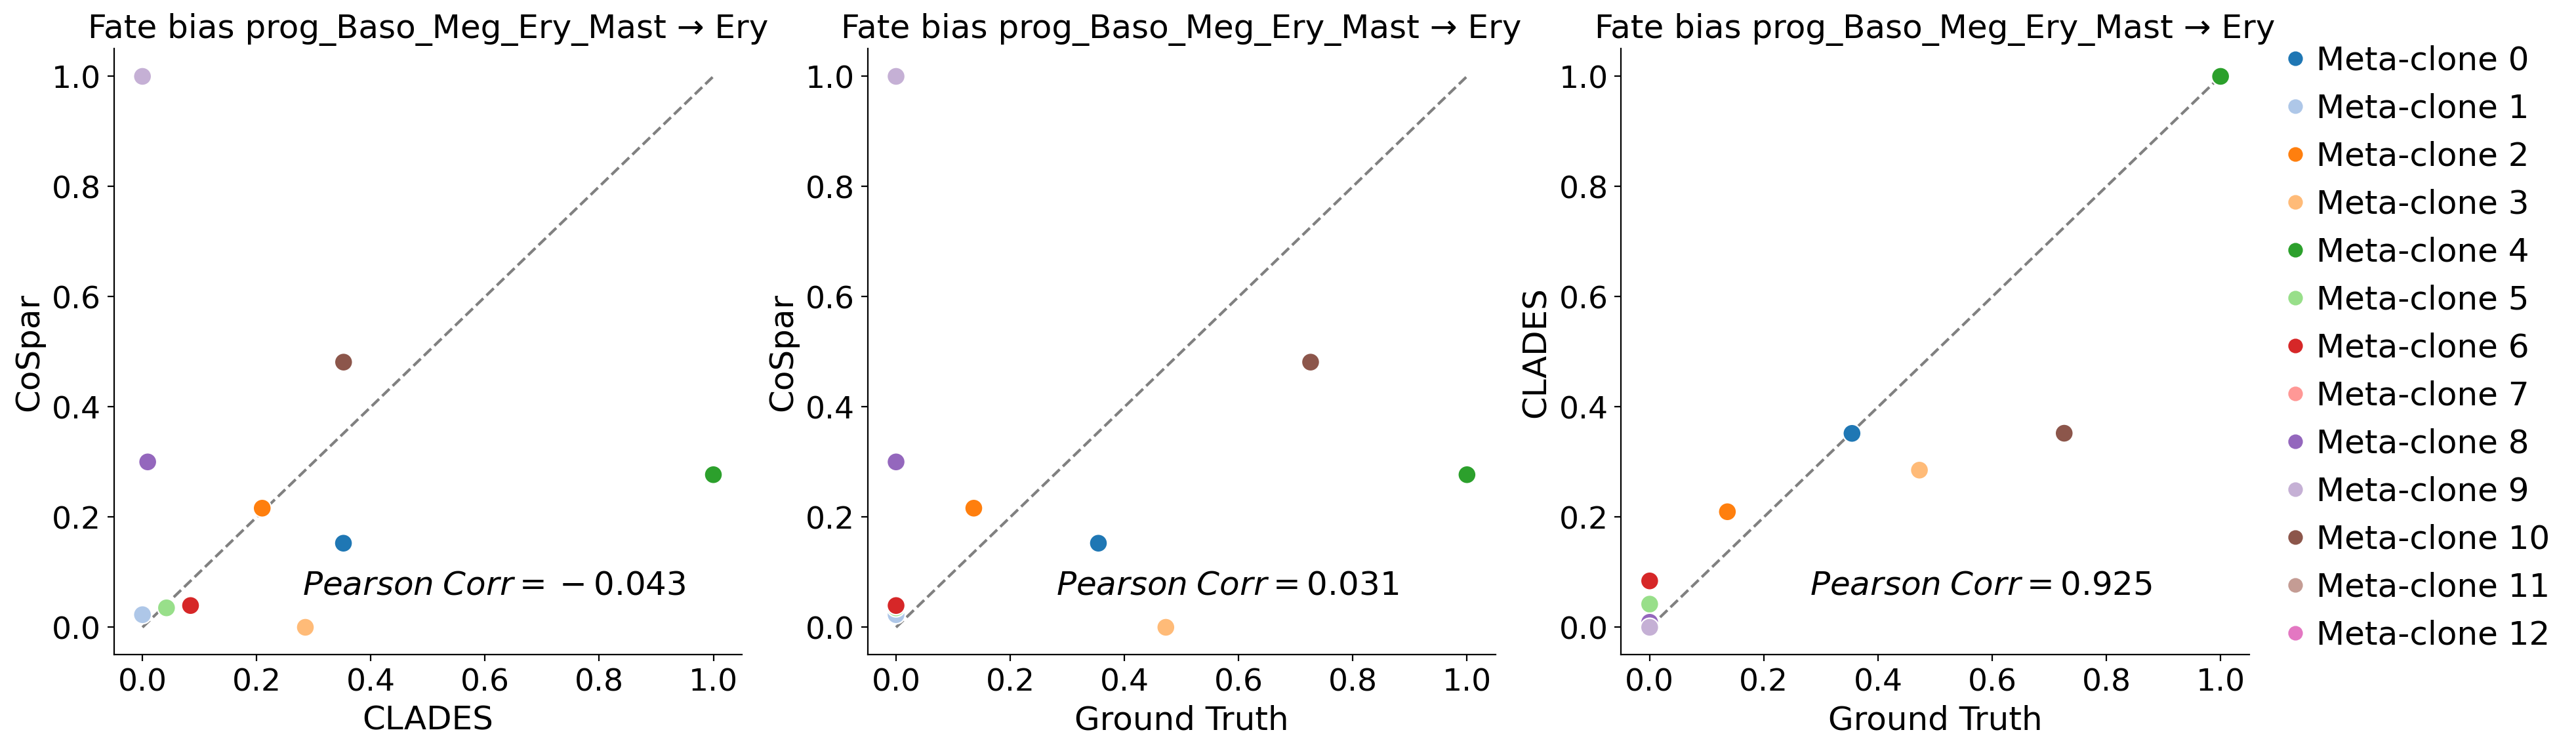

In [52]:
with_cospar(
    adata_all_latert, 
    adata, 
    'prog_Baso_Meg_Ery_Mast', 
    'Ery', 
    model, 
    cluster_names,
    gillespie_dir,
    save='eryexample'
)